In [7]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os 
import warnings 
warnings.simplefilter('ignore')

In [8]:
from IPython.display import display, HTML

In [14]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [16]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler, RobustScaler, Imputer

In [17]:
from sklearn.linear_model import SGDClassifier, LogisticRegression

In [18]:
from sklearn.metrics import roc_auc_score

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
print(os.getcwd())

/Users/fairy/Documents/data science/kaggle_summer18/code


In [24]:
cd input

/Users/fairy/Documents/data science/kaggle_summer18/code/input


In [26]:
print(os.listdir("../input"))

['application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


In [27]:
data_train = pd.read_csv('../input/application_train.csv')

In [28]:
print(list(data_train.columns))

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

In [29]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB



Fisrtly, see the distributions of continious variables in dataset according to their class
and find variables that have significant difference between classes and can 
have a bigger impact inside the model.


In [57]:
print(len(data_train['TARGET'].dropna())/data_train.shape[0] > 0.6)

True


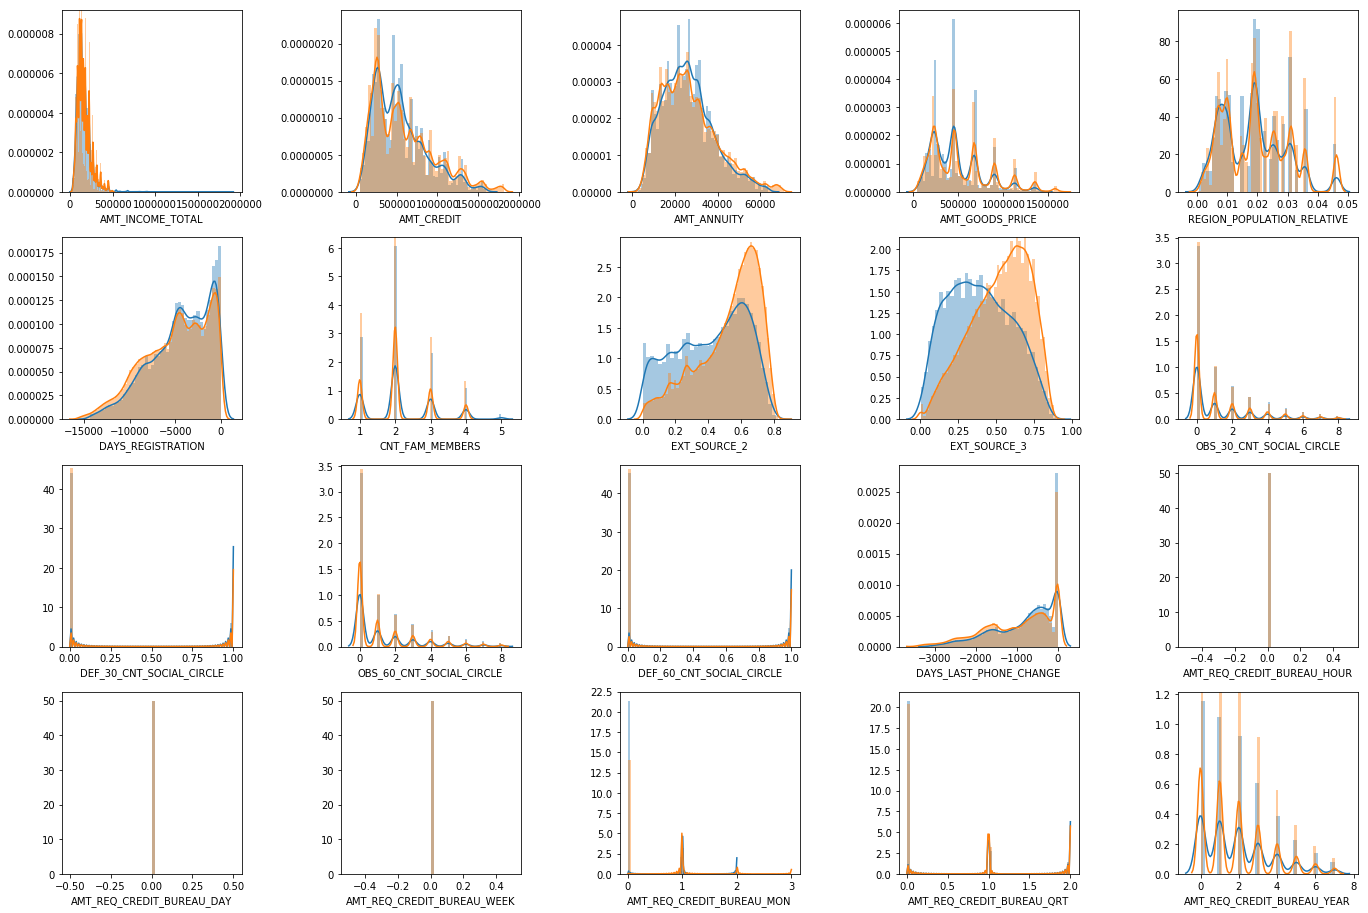

In [66]:
index = 0
for i in data_train.drop(columns = 'SK_ID_CURR').columns:
    if (np.dtype(data_train[i]) == 'float64') and (len(data_train[i].dropna())/data_train.shape[0]>0.6):
        index +=1
        plt.subplot(4,5,index)
        curr_feature_1 = data_train[i][data_train.TARGET == 1].dropna()
        curr_feature_0 = data_train[i][data_train.TARGET == 0].dropna()
        sns.distplot(curr_feature_1[abs(stats.zscore(curr_feature_1)) < 3])
        sns.distplot(curr_feature_0[abs(stats.zscore(curr_feature_0)) < 3])
        
plt.subplots_adjust(top=3, bottom=0, left=0, right=3, hspace=0.25, wspace=0.55)
plt.show()
        

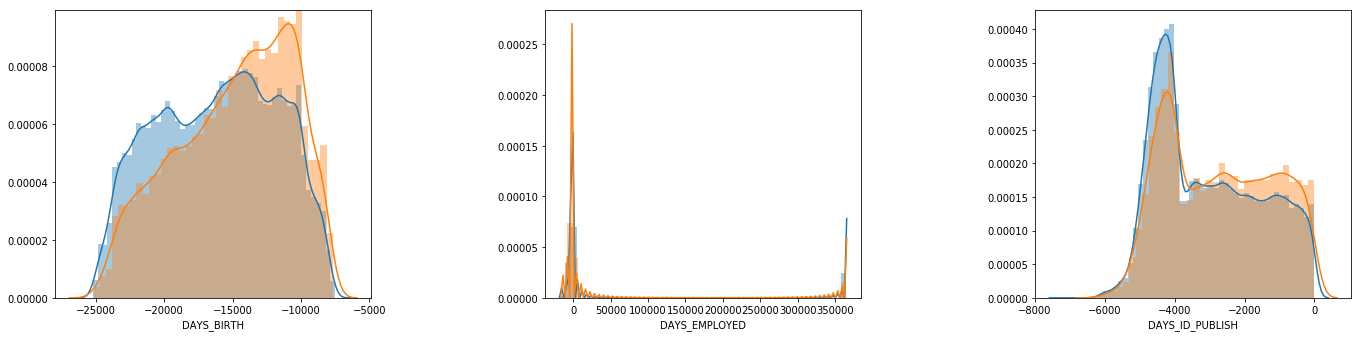

In [75]:
index = 0
for i in data_train.drop(columns = ['SK_ID_CURR','TARGET']).columns:
    if np.dtype(data_train[i]) == 'int64' and len(data_train[i].dropna())/data_train.shape[0] > 0.6\
    and len(data_train[i].unique()) > 50:
        index += 1
        plt.subplot(1,3,index)
        curr_feature_1 = data_train[i][data_train.TARGET == 1].dropna()
        curr_feature_0 = data_train[i][data_train.TARGET == 0].dropna()
        sns.distplot(curr_feature_0)
        sns.distplot(curr_feature_1)
plt.subplots_adjust(top=1, bottom=0, left=0, right=3, hspace=0.25, wspace=0.55)
plt.show()
       



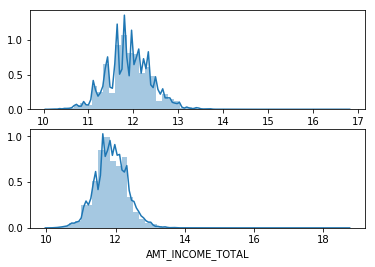

In [76]:
plt.subplot(211)
sns.distplot(np.log(data_train.AMT_INCOME_TOTAL[data_train.TARGET == 0] + 1))
plt.subplot(212)
sns.distplot(np.log(data_train.AMT_INCOME_TOTAL[data_train.TARGET == 1] + 1))
plt.show()

In [77]:
sum(np.log(data_train.AMT_INCOME_TOTAL + 1)> 14) #outliers 

158

In [82]:
index = 0
for i in data_train.drop(columns = ['SK_ID_CURR','TARGET']).columns:
    if np.dtype(data_train[i]) == 'O' and len(data_train[i].dropna())/data_train.shape[0] > 0.6:
        tab = pd.crosstab(data_train.TARGET, data_train[i], margins = True)
        display(HTML((tab/tab.loc[tab.index[-1]]).to_html()))

NAME_CONTRACT_TYPE,Cash loans,Revolving loans,All
TARGET,,,
0,0.916541,0.945217,0.919271
1,0.083459,0.054783,0.080729
All,1.000000,1.000000,1.000000


CODE_GENDER,F,M,XNA,All
TARGET,,,,
0,0.930007,0.898581,1.0,0.919271
1,0.069993,0.101419,0.0,0.080729
All,1.000000,1.000000,1.0,1.000000


FLAG_OWN_CAR,N,Y,All
TARGET,,,
0,0.914998,0.927563,0.919271
1,0.085002,0.072437,0.080729
All,1.000000,1.000000,1.000000


FLAG_OWN_REALTY,N,Y,All
TARGET,,,
0,0.916751,0.920384,0.919271
1,0.083249,0.079616,0.080729
All,1.000000,1.000000,1.000000


NAME_TYPE_SUITE,Children,Family,Group of people,Other_A,Other_B,"Spouse, partner",Unaccompanied,All
TARGET,,,,,,,,
0,0.926232,0.925054,0.915129,0.91224,0.901695,0.921284,0.91817,0.919159
1,0.073768,0.074946,0.084871,0.08776,0.098305,0.078716,0.08183,0.080841
All,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000


NAME_INCOME_TYPE,Businessman,Commercial associate,Maternity leave,Pensioner,State servant,Student,Unemployed,Working,All
TARGET,,,,,,,,,
0,1.0,0.925157,0.6,0.946136,0.94245,1.0,0.636364,0.904115,0.919271
1,0.0,0.074843,0.4,0.053864,0.05755,0.0,0.363636,0.095885,0.080729
All,1.0,1.000000,1.0,1.000000,1.00000,1.0,1.000000,1.000000,1.000000


NAME_EDUCATION_TYPE,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special,All
TARGET,,,,,,
0,0.981707,0.946449,0.91515,0.890723,0.910601,0.919271
1,0.018293,0.053551,0.08485,0.109277,0.089399,0.080729
All,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow,All
TARGET,,,,,,,
0,0.900554,0.924401,0.918058,0.901923,1.0,0.941758,0.919271
1,0.099446,0.075599,0.081942,0.098077,0.0,0.058242,0.080729
All,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000


NAME_HOUSING_TYPE,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents,All
TARGET,,,,,,,
0,0.920677,0.922043,0.914603,0.934276,0.876869,0.883019,0.919271
1,0.079323,0.077957,0.085397,0.065724,0.123131,0.116981,0.080729
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff,All
TARGET,,,,,,,,,,,,,,,,,,,
0,0.951697,0.903933,0.89556,0.93696,0.886739,0.936057,0.938401,0.935361,0.894212,0.828476,0.93786,0.932998,0.934012,0.921438,0.903682,0.929502,0.892576,0.88724,0.912149
1,0.048303,0.096067,0.10444,0.06304,0.113261,0.063943,0.061599,0.064639,0.105788,0.171524,0.06214,0.067002,0.065988,0.078562,0.096318,0.070498,0.107424,0.11276,0.087851
All,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


WEEKDAY_APPR_PROCESS_START,FRIDAY,MONDAY,SATURDAY,SUNDAY,THURSDAY,TUESDAY,WEDNESDAY,All
TARGET,,,,,,,,
0,0.918531,0.922428,0.921127,0.920709,0.918997,0.916495,0.918396,0.919271
1,0.081469,0.077572,0.078873,0.079291,0.081003,0.083505,0.081604,0.080729
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


ORGANIZATION_TYPE,Advertising,Agriculture,Bank,Business Entity Type 1,Business Entity Type 2,Business Entity Type 3,Cleaning,Construction,Culture,Electricity,Emergency,Government,Hotel,Housing,Industry: type 1,Industry: type 10,Industry: type 11,Industry: type 12,Industry: type 13,Industry: type 2,Industry: type 3,Industry: type 4,Industry: type 5,Industry: type 6,Industry: type 7,Industry: type 8,Industry: type 9,Insurance,Kindergarten,Legal Services,Medicine,Military,Mobile,Other,Police,Postal,Realtor,Religion,Restaurant,School,Security,Security Ministries,Self-employed,Services,Telecom,Trade: type 1,Trade: type 2,Trade: type 3,Trade: type 4,Trade: type 5,Trade: type 6,Trade: type 7,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,XNA,All
TARGET,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.918415,0.895273,0.948145,0.918616,0.914716,0.907004,0.888462,0.883202,0.944591,0.933684,0.928571,0.930219,0.935818,0.920554,0.889317,0.93578,0.913462,0.96206,0.865672,0.927948,0.893838,0.898518,0.931553,0.928571,0.919663,0.875,0.933195,0.943049,0.929651,0.921311,0.934155,0.948747,0.908517,0.923575,0.950021,0.915624,0.893939,0.941176,0.882938,0.940852,0.900216,0.951368,0.898261,0.933968,0.923744,0.91092,0.93,0.896621,0.96875,0.938776,0.954041,0.905504,0.955224,0.92196,0.84246,0.907188,0.951017,0.946004,0.919271
1,0.081585,0.104727,0.051855,0.081384,0.085284,0.092996,0.111538,0.116798,0.055409,0.066316,0.071429,0.069781,0.064182,0.079446,0.110683,0.06422,0.086538,0.03794,0.134328,0.072052,0.106162,0.101482,0.068447,0.071429,0.080337,0.125,0.066805,0.056951,0.070349,0.078689,0.065845,0.051253,0.091483,0.076425,0.049979,0.084376,0.106061,0.058824,0.117062,0.059148,0.099784,0.048632,0.101739,0.066032,0.076256,0.08908,0.07,0.103379,0.03125,0.061224,0.045959,0.094496,0.044776,0.07804,0.15754,0.092812,0.048983,0.053996,0.080729
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000


Hypotheses testing 
In this block, they perform chi-square test for those variables that seem to have significant association with TARGET.

In [103]:
def chi_test(data, feature, target ='TARGET', group_classes=False):
    
    if sum(pd.isna(data[feature])):
        data[feature].replace(np.nan,'Unknown',inplace=True)
        
    cnt_table = pd.crosstab(data[target],data[feature]) #to check if there are enough obervations in each class
    
    if group_classes:
        tab = pd.crosstab(data[target], data[feature], margins=True)
        tab = tab/tab.loc[tab.index[-1]]
        labels = {}
        for i in cnt_table.columns:
            if tab[i][1] > tab['All'][1]:
                labels[i] = 'High risk'
            else:
                labels[i] = 'Low risk'
            
        cnt_bi_table = pd.crosstab(data[target], data[feature].replace(labels))
        chi = stats.chi2_contingency(cnt_bi_table)
        display(HTML(pd.crosstab(data[target], data[feature].replace(labels),margins = True).to_html()))
        print({'Chi-square statistc': chi[0],
              'p-value': chi[1],
              'df': chi[2]})
        return labels
    else:
        chi = stats.chi2_contingency(cnt_table)
        display(HTML(pd.crosstab(data[target],data[feature],margins=True).to_html()))
        print({'Chi-square statistic': chi[0],
             'p-value': chi[1],
             'df': chi[2]})
                    

In [97]:
chi_test(data_train[data_train.CODE_GENDER != 'XNA'],'CODE_GENDER')

CODE_GENDER,F,M,All
TARGET,,,
0,188278,94404,282682
1,14170,10655,24825
All,202448,105059,307507


{'Chi-square statistic': 920.0057254249849, 'p-value': 4.394091339983112e-202, 'df': 1}


In [104]:
inc_labels = chi_test(data_train, 'NAME_INCOME_TYPE',group_classes=True)

NAME_INCOME_TYPE,High risk,Low risk,All
TARGET,,,
0,143567,139119,282686
1,15234,9591,24825
All,158801,148710,307511


{'Chi-square statistc': 1022.2458887086157, 'p-value': 2.62339845557261e-224, 'df': 1}


In [105]:
hsng_labels = chi_test(data_train, 'NAME_HOUSING_TYPE',group_classes=True)

NAME_HOUSING_TYPE,High risk,Low risk,All
TARGET,,,
0,27612,255074,282686
1,3292,21533,24825
All,30904,276607,307511


{'Chi-square statistc': 307.64709917361216, 'p-value': 7.108770671170459e-69, 'df': 1}


In [107]:
occup_labels = chi_test(data_train, 'OCCUPATION_TYPE',group_classes=True)

OCCUPATION_TYPE,High risk,Low risk,All
TARGET,,,
0,113314,169372,282686
1,13338,11487,24825
All,126652,180859,307511


{'Chi-square statistc': 1753.0884810292614, 'p-value': 0.0, 'df': 1}


In [109]:
orgn_labels = chi_test(data_train,'ORGANIZATION_TYPE',group_classes=True)

ORGANIZATION_TYPE,High risk,Low risk,All
TARGET,,,
0,150847,131839,282686
1,16131,8694,24825
All,166978,140533,307511


{'Chi-square statistc': 1240.5868105813465, 'p-value': 9.220915322133472e-272, 'df': 1}


In [110]:
data_train.shape

(307511, 122)

In [111]:
print(sum(data_train.FLAG_OWN_CAR == 'Y'))
print(data_train.OWN_CAR_AGE.dropna().shape)

104587
(104582,)


In [112]:
data_train.OWN_CAR_AGE.fillna(value =0, inplace=True)

In [113]:
print(data_train.OCCUPATION_TYPE.unique())

['Laborers' 'Core staff' 'Accountants' 'Managers' 'Unknown' 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']


In [114]:
data_train.OCCUPATION_TYPE.fillna(value = 'Unknown',inplace = True)

In [115]:
print(sum(data_train.FLAG_MOBIL == 0))
print(sum(data_train.FLAG_MOBIL == 1))

1
307510


In [117]:
print(sum(data_train.FLAG_CONT_MOBILE == 0))
print(sum(data_train.FLAG_CONT_MOBILE == 1))

574
306937


In [118]:
data_train.drop(columns=['FLAG_MOBIL','FLAG_CONT_MOBILE'],inplace=True)

In [119]:
data_train.shape

(307511, 120)

In [120]:
data_train['DOC_COUNT'] = data_train.FLAG_DOCUMENT_2

for i in range(3,22):
    data_train['DOC_COUNT'] = data_train['DOC_COUNT'] + data_train['FLAG_DOCUMENT_'+str(i)]

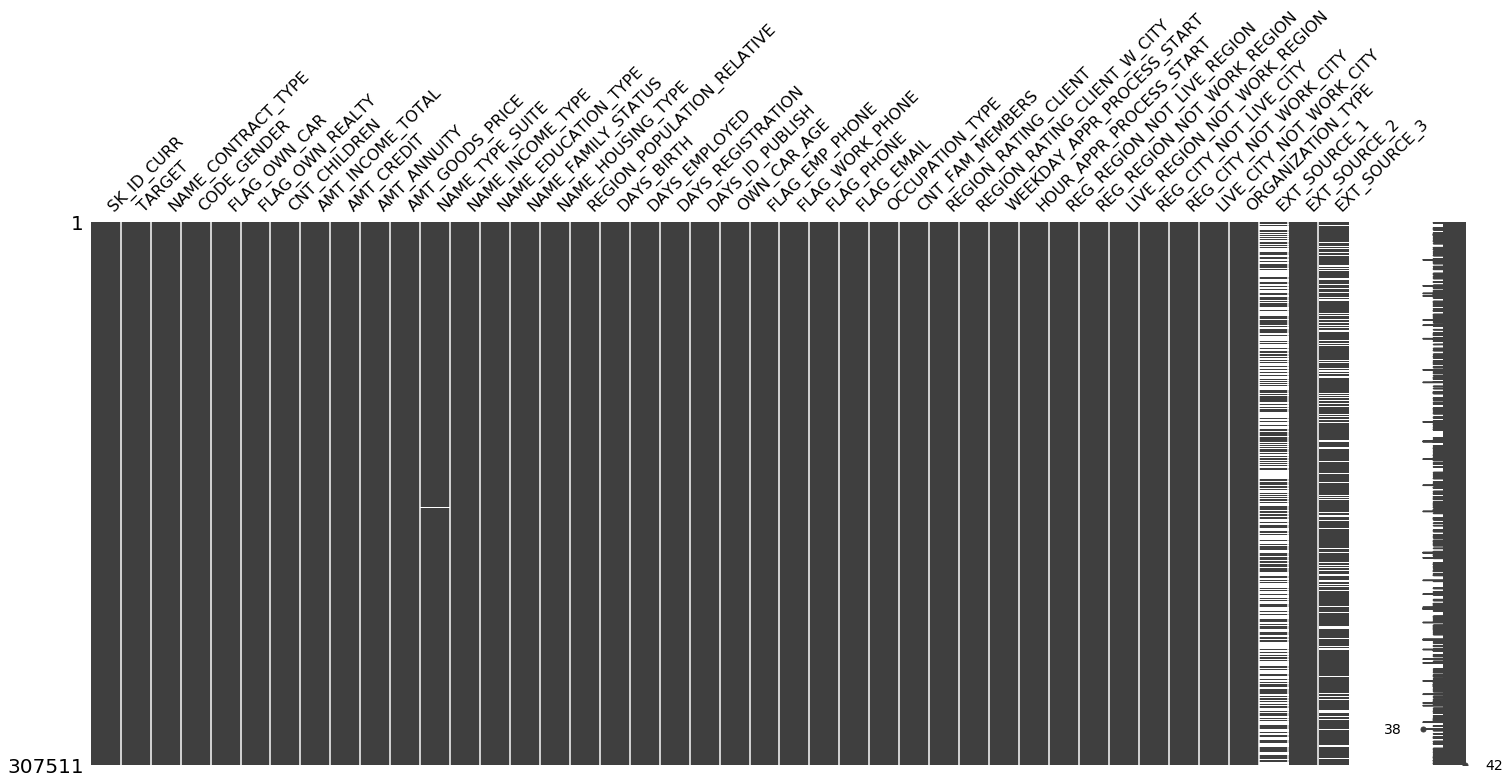

In [121]:
msno.matrix(data_train.iloc[:,0:42])
plt.show()

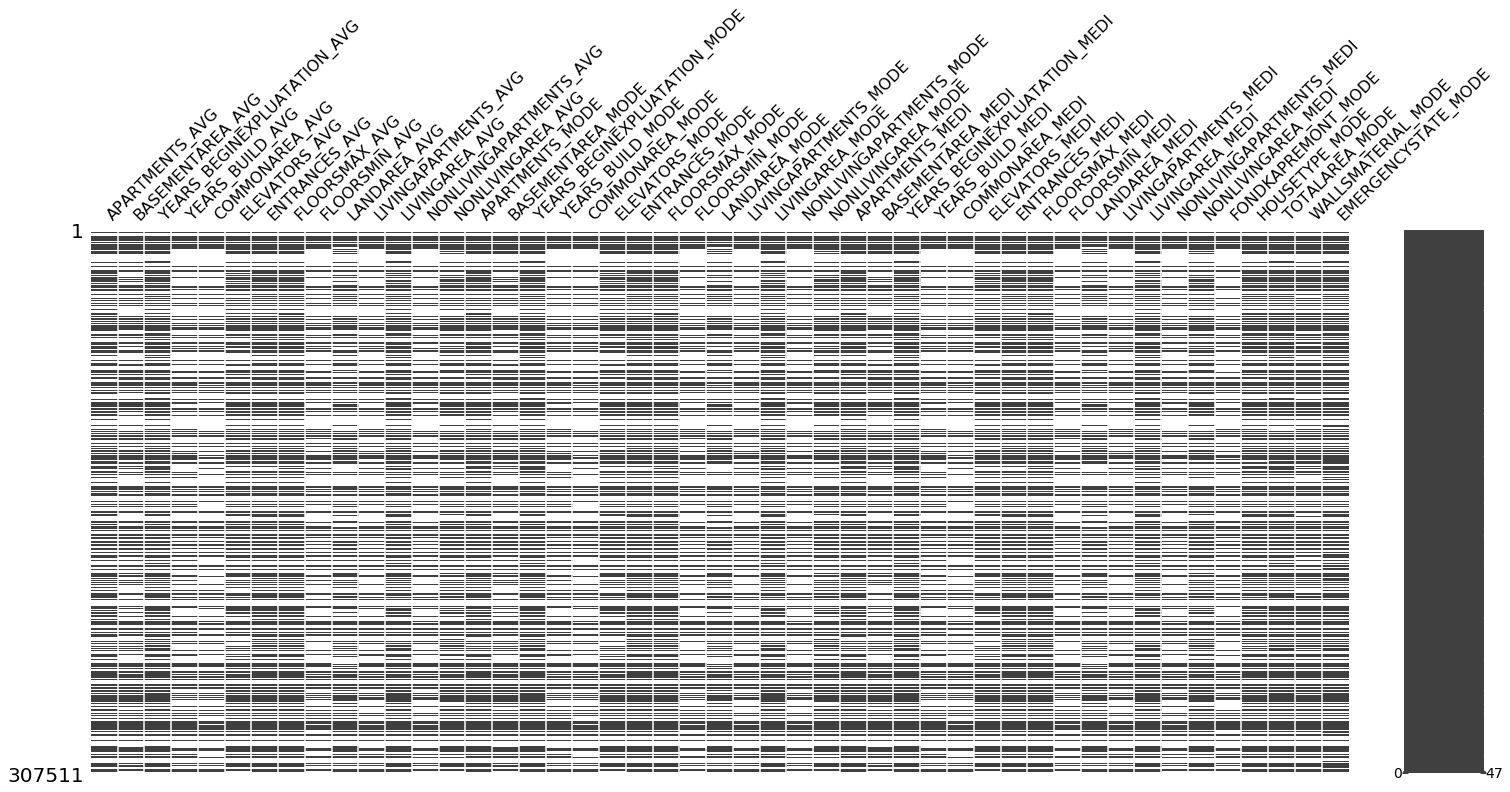

In [122]:
msno.matrix(data_train.iloc[:,42:89])
plt.show()

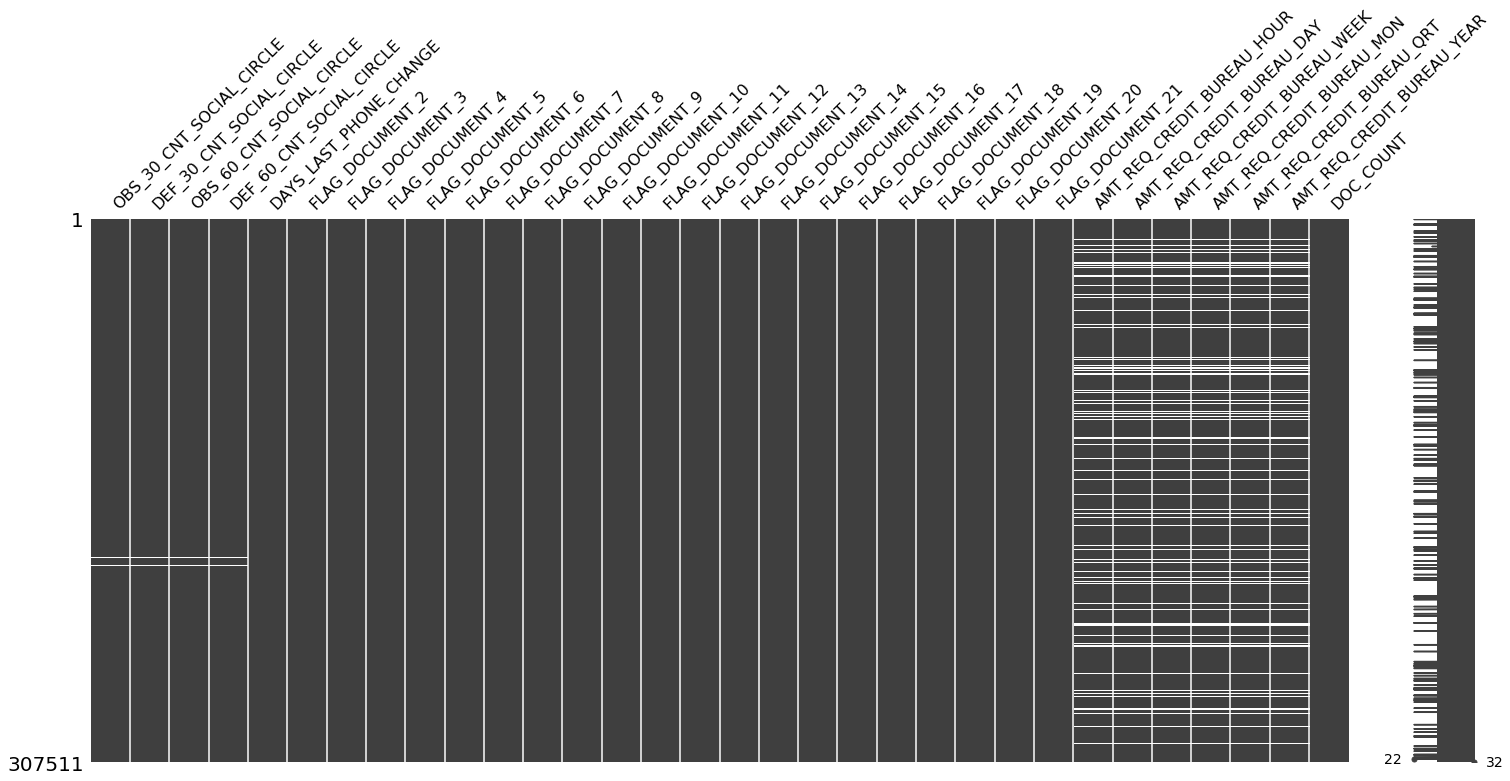

In [123]:
msno.matrix(data_train.iloc[:,89:])
plt.show()

In [124]:
for i in data_train.iloc[:,42:56].columns:
    data_train[i] = -pd.isna(data_train[i])

In [125]:
for i in data_train.iloc[:,84:89].columns:
    data_train[i] = -pd.isna(data_train[i])

In [126]:
data_train['HOUSE_INFO'] = (data_train.iloc[:,84:89].sum(axis=1)+ data_train.iloc[:,42:56].sum\
                            (axis=1))/19

In [128]:
data_train.drop(columns = data_train.iloc[:,94:114].columns, inplace=True)
data_train.drop(columns = data_train.iloc[:,42:89].columns, inplace=True)
data_train.drop(columns = 'EXT_SOURCE_1',inplace=True)

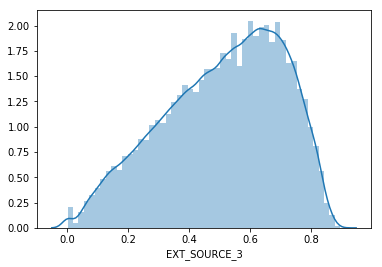

In [129]:
sns.distplot(data_train.EXT_SOURCE_3.dropna())

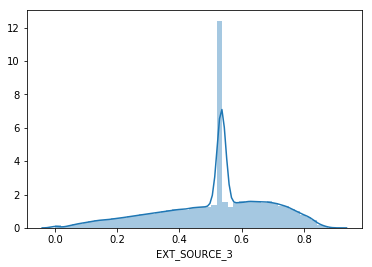

In [130]:
sns.distplot(data_train.EXT_SOURCE_3.fillna(data_train.EXT_SOURCE_3.dropna().median()))

In [131]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 54 columns):
SK_ID_CURR                     307511 non-null int64
TARGET                         307511 non-null int64
NAME_CONTRACT_TYPE             307511 non-null object
CODE_GENDER                    307511 non-null object
FLAG_OWN_CAR                   307511 non-null object
FLAG_OWN_REALTY                307511 non-null object
CNT_CHILDREN                   307511 non-null int64
AMT_INCOME_TOTAL               307511 non-null float64
AMT_CREDIT                     307511 non-null float64
AMT_ANNUITY                    307499 non-null float64
AMT_GOODS_PRICE                307233 non-null float64
NAME_TYPE_SUITE                306219 non-null object
NAME_INCOME_TYPE               307511 non-null object
NAME_EDUCATION_TYPE            307511 non-null object
NAME_FAMILY_STATUS             307511 non-null object
NAME_HOUSING_TYPE              307511 non-null object
REGION_POPULATION_RELATI

In [132]:
to_be_scaled = ['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_ID_PUBLISH']
for i in data_train.columns:
    if data_train[i].dtype == 'float64':
        to_be_scaled.append(i)

In [134]:
print(to_be_scaled)

['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'HOUSE_INFO']


In [135]:
for i in data_train.columns:
    if data_train[i].dtype == 'O':
        print([i,data_train[i].unique()])

['NAME_CONTRACT_TYPE', array(['Cash loans', 'Revolving loans'], dtype=object)]
['CODE_GENDER', array(['M', 'F', 'XNA'], dtype=object)]
['FLAG_OWN_CAR', array(['N', 'Y'], dtype=object)]
['FLAG_OWN_REALTY', array(['Y', 'N'], dtype=object)]
['NAME_TYPE_SUITE', array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children',
       'Other_A', nan, 'Other_B', 'Group of people'], dtype=object)]
['NAME_INCOME_TYPE', array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
      dtype=object)]
['NAME_EDUCATION_TYPE', array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)]
['NAME_FAMILY_STATUS', array(['Single / not married', 'Married', 'Civil marriage', 'Widow',
       'Separated', 'Unknown'], dtype=object)]
['NAME_HOUSING_TYPE', array(['House / apartment', 'Rented apartment', 'With parents',
       'Municipal apartment', 

In [136]:
sum(data_train.CODE_GENDER == 'XNA')

4

In [138]:
data_train.CODE_GENDER.replace('XNA', 'F', inplace=True)
data_train.NAME_INCOME_TYPE.replace(inc_labels, inplace=True)
data_train.OCCUPATION_TYPE.replace(occup_labels, inplace=True)
data_train.ORGANIZATION_TYPE.replace(orgn_labels, inplace=True)
data_train.WEEKDAY_APPR_PROCESS_START.replace({'WEDNESDAY': 'Week', 'MONDAY': 'Week', 'THURSDAY': 'Week', 'SUNDAY': 'Weekend',
                                               'SATURDAY': 'Weekend', 'FRIDAY': 'Week', 'TUESDAY': 'Week'}, inplace=True)

In [139]:
data_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DOC_COUNT,HOUSE_INFO
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


In [142]:
binarizer = LabelBinarizer()

In [143]:
for i in data_train.columns:
    if data_train[i].dtype == 'O' and len(data_train[i].unique()) == 2:
        data_train[i] = binarizer.fit_transform(data_train[i])

In [144]:
encoder = LabelEncoder()

In [145]:
sum(data_train.NAME_TYPE_SUITE.isnull())

1292

In [146]:
data_train.NAME_TYPE_SUITE = encoder.fit_transform(data_train.NAME_TYPE_SUITE.replace(np.nan, 'Unknown'))

In [148]:
print( encoder.classes_ )
sum(data_train.NAME_TYPE_SUITE == 7)

['Children' 'Family' 'Group of people' 'Other_A' 'Other_B'
 'Spouse, partner' 'Unaccompanied' 'Unknown']


1292

In [149]:
data_train.NAME_TYPE_SUITE.replace('Unknown', np.nan, inplace=True)

In [150]:
data_train.NAME_EDUCATION_TYPE = encoder.fit_transform(data_train.NAME_EDUCATION_TYPE)

In [151]:
encoder.classes_ #ordered

array(['Academic degree', 'Higher education', 'Incomplete higher',
       'Lower secondary', 'Secondary / secondary special'], dtype=object)

In [152]:
data_train = pd.get_dummies(data_train)

In [153]:
data_train.shape

(307511, 64)

In [154]:
impute = Imputer()